# Step 0: initial attempts
If you're going to use `Magenta`, you need to install it and its dependencies. Some of the later examples will also download other dependencies (such as models and checkpoints)

In [53]:
#@test {"output": "ignore"}

print 'Installing dependencies...'
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi

!pip install -qU magenta

# Hack to allow python to pick up the newly-installed fluidsynth lib. 
# This is only needed for the hosted Colab environment.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library

print 'Importing libraries and defining some helper functions...'
from google.colab import files

import magenta.music as mm
import magenta
import tensorflow
from magenta.protobuf import music_pb2


print '🎉 Done!'
print magenta.__version__ 
print tensorflow.__version__

Installing dependencies...
/bin/sh: apt-get: command not found
You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
google-api-core 1.8.2 has requirement setuptools>=34.0.0, but you'll have setuptools 28.8.0 which is incompatible.
tensorboard 1.13.1 has requirement werkzeug>=0.11.15, but you'll have werkzeug 0.10.4 which is incompatible.
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/Library/Frameworks/Python.framework/Versions/2.7/share/doc/networkx-1.8.1'
Consider using the `--user` option or check the permissions.

You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Importing libraries and defining some helper functions...


ImportError: No module named google.colab

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division
import pandas as pd
from numpy import random

# overall features (same for all stimuli)
totbar = 12
# speed
bpm = 140
bdura = 60/bpm/3

Make a drum solo!

In [2]:
# basic beat pattern
allf = []
for beatbar in [1/2,1,2,3,4,6,12]:
  nrep = totbar/beatbar
  beatunit = 0.5
  beat = np.random.randint(2,size=int(beatbar*4/beatunit))
  fullbt = list(beat)*int(nrep)


  # create sequence
  drums = music_pb2.NoteSequence()
  for k,kb in enumerate(fullbt):
    if kb:
      drums.notes.add(pitch=36, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
      # instrument & velocity: don't know how it affects anything

  # This is a colab utility method that visualizes a NoteSequence.
  mm.plot_sequence(drums)

  # save midi file
  fname='sample_%dbeat_period.mid'%(beatbar*4)
  mm.sequence_proto_to_midi_file(drums, fname)
  allf.append(fname)

  # This is a colab utility method that plays a NoteSequence.
  mm.play_sequence(drums,synth=mm.fluidsynth) 

for f in allf: # save to the disk
  files.download(f)


NameError: name 'music_pb2' is not defined

## "Clock Model" based drum solo generation

Create patterns according to a generative "clock model" (Essens 1995).

Clock model includes 2 parts: how long is the cycle (how many beats), and where does the cycle start (the downbeat). A clock fitting a drum pattern well should always have the downbeat colliding with the "accented tones". Here I simply use a drum note with 2 pitches overlapped as accented tones.

In [0]:
# overall features (same for all stimuli)
totbar = 24
# speed
bpm = 140
bdura = 60/bpm/3

# generative model 1: fixed clock, fixed pattern that repeats in each clock period
clock = [1,0,0,0]
beatbar = 1
nrep = totbar/beatbar
beatunit = 1
beat = np.random.randint(2,size=int(beatbar*4/beatunit))
beat[np.array(clock)==1]=2
fullbt = list(beat)*int(nrep)

# create sequence
drums = music_pb2.NoteSequence()
for k,kb in enumerate(fullbt):
  if kb:
    drums.notes.add(pitch=36, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
  if kb>1:
    drums.notes.add(pitch=42, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
    # instrument & velocity: don't know how it affects anything

# This is a colab utility method that visualizes a NoteSequence.
mm.plot_sequence(drums)

# save midi file
fname='sample_simpleclock.mid'
mm.sequence_proto_to_midi_file(drums, fname)


# This is a colab utility method that plays a NoteSequence.
mm.play_sequence(drums,synth=mm.fluidsynth) 
files.download(fname)

Loading BokehJS ...

In [0]:
# model 2: same clock but with variants in cycles
clock = [1,0,0,0]
beatbar = 1
nrep = totbar/beatbar
nchunk = 4
beatunit = 1
fullbt=[]
for kchk in range(nchunk): 
  beat = np.random.randint(2,size=int(beatbar*4/beatunit))
  beat[np.array(clock)==1]=2
  print(beat)
  fullbt = fullbt +list(beat)
fullbt = fullbt*int(nrep/nchunk)

# create sequence
drums = music_pb2.NoteSequence()
for k,kb in enumerate(fullbt):
  if kb:
    drums.notes.add(pitch=36, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
  if kb>1:
    drums.notes.add(pitch=42, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
    # instrument & velocity: don't know how it affects anything

# This is a colab utility method that visualizes a NoteSequence.
mm.plot_sequence(drums)

# save midi file
fname='sample2_fxclk_chngpatrn_%dchunks.mid'%nchunk
mm.sequence_proto_to_midi_file(drums, fname)


# This is a colab utility method that plays a NoteSequence.
mm.play_sequence(drums,synth=mm.fluidsynth) 
files.download(fname)

[2 1 1 1]
[2 0 0 1]
[2 0 1 1]
[2 0 1 0]


Loading BokehJS ...

In [0]:
# model 3: different clocks with same cycle but diff phase
beatbar = 1
nrep = totbar/beatbar
beatunit = 1

allclocks = [[1,0,0,0],[0,0,1,0]]
nchunk = 2
fullbt=[]
for clock in allclocks:
  for k in range(nchunk):
    beat = np.random.randint(2,size=int(beatbar*4/beatunit))
    beat[np.array(clock)==1]=2
    print(beat)
    fullbt = fullbt +list(beat)
fullbt = fullbt*int(nrep/nchunk/len(allclocks))
print(fullbt)
# create sequence
drums = music_pb2.NoteSequence()
for k,kb in enumerate(fullbt):
  if kb:
    drums.notes.add(pitch=36, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
  if kb>1:
    drums.notes.add(pitch=42, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
    # instrument & velocity: don't know how it affects anything

# This is a colab utility method that visualizes a NoteSequence.
mm.plot_sequence(drums)

# save midi file
fname='sample3_chgclk.mid'
mm.sequence_proto_to_midi_file(drums, fname)


# This is a colab utility method that plays a NoteSequence.
mm.play_sequence(drums,synth=mm.fluidsynth) 
files.download(fname)

[2 1 0 0]
[2 1 1 0]
[1 1 2 1]
[0 0 2 0]
[2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 2, 1, 0, 0, 2, 0, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 2, 1, 0, 0, 2, 0, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 2, 1, 0, 0, 2, 0]


Loading BokehJS ...

In [0]:
# model 4: different clocks with diff cycle
beatbar = 1
totbar = 64
nrep = totbar/beatbar
beatunit = 1

allclocks = [[1,0,0,0],[1,0,0]]
nchunk = 4
fullbt=[]
for clock in allclocks:
  for k in range(nchunk):
    beat = np.random.randint(2,size=int(beatbar*len(clock)/beatunit))
    beat[np.array(clock)==1]=2
    print(beat)
    fullbt = fullbt +list(beat)
fullbt = fullbt*int(nrep/nchunk/len(allclocks))
print(fullbt)
# create sequence
drums = music_pb2.NoteSequence()
for k,kb in enumerate(fullbt):
  if kb:
    drums.notes.add(pitch=36, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
  if kb>1:
    drums.notes.add(pitch=42, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
    # instrument & velocity: don't know how it affects anything

# This is a colab utility method that visualizes a NoteSequence.
mm.plot_sequence(drums)

# save midi file
fname='sample4_chgclkcyclen.mid'
mm.sequence_proto_to_midi_file(drums, fname)


# This is a colab utility method that plays a NoteSequence.
mm.play_sequence(drums,synth=mm.fluidsynth) 
files.download(fname)

[2 0 1 0]
[2 1 0 1]
[2 1 1 1]
[2 1 0 0]
[2 0 1]
[2 0 1]
[2 1 0]
[2 1 1]
[2, 0, 1, 0, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1]


Loading BokehJS ...

In [0]:
# create sequence
drums = music_pb2.NoteSequence()
for k,kb in enumerate(fullbt):
  if kb:
    drums.notes.add(pitch=36, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
  #if kb>1:
  #  drums.notes.add(pitch=42, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
    # instrument & velocity: don't know how it affects anything

# This is a colab utility method that visualizes a NoteSequence.
mm.plot_sequence(drums)

# save midi file
fname='sample4a_chgclkcyclen_noaccent.mid'
mm.sequence_proto_to_midi_file(drums, fname)


# This is a colab utility method that plays a NoteSequence.
mm.play_sequence(drums,synth=mm.fluidsynth) 
files.download(fname)

Loading BokehJS ...

In [0]:
# model 5: probabilistic transition
beatbar = 1
totbar = 64
nrep = totbar/beatbar
beatunit = 1

allclocks = [[1,0,0,0],[1,0,0]]
nchunk = 2
allchunks = [[[] for kk in range(nchunk)] for k in allclocks]
for kc,clock in enumerate(allclocks):
  for k in range(nchunk):
    beat = np.random.randint(2,size=int(beatbar*len(clock)/beatunit))
    beat[np.array(clock)==1]=2
    print(beat)
    allchunks[kc][k] = list(beat)

transprob = [[0.9,0.1],[0.5,0.5]]
for k0 in range(nchunk):
  fullbt=[]
  for kchk in range(int(nrep/nchunk/len(allclocks))):
    trans = int(np.random.rand(1)<transprob[k0][0])
    fullbt += allchunks[0][0]+allchunks[1][trans]
  print(fullbt)
  # create sequence
  drums = music_pb2.NoteSequence()
  for k,kb in enumerate(fullbt):
    if kb:
      drums.notes.add(pitch=36, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
    if kb>1:
      drums.notes.add(pitch=42, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
      # instrument & velocity: don't know how it affects anything

  # This is a colab utility method that visualizes a NoteSequence.
  mm.plot_sequence(drums)

  # save midi file
  fname='sample5_%d_probtrans.mid'%k0
  mm.sequence_proto_to_midi_file(drums, fname)


  # This is a colab utility method that plays a NoteSequence.
  mm.play_sequence(drums,synth=mm.fluidsynth) 
  files.download(fname)

[2 0 0 0]
[2 0 1 0]
[2 0 0]
[2 1 1]
[2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1]


Loading BokehJS ...

[2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1]


Loading BokehJS ...

In [0]:
# model 6: switching to a new clock
fullbt = [2,0,0,1,2,0,0,1,2,0,0,1,2,1,0,2,0,1,2,0,1,2,0,1,2,0,1]*4
# create sequence
drums = music_pb2.NoteSequence()
for k,kb in enumerate(fullbt):
  if kb:
    drums.notes.add(pitch=36, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
  if kb>1:
    drums.notes.add(pitch=42, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
    # instrument & velocity: don't know how it affects anything

# This is a colab utility method that visualizes a NoteSequence.
mm.plot_sequence(drums)

# save midi file
fname='sample6_clockswitch.mid'
mm.sequence_proto_to_midi_file(drums, fname)


# This is a colab utility method that plays a NoteSequence.
mm.play_sequence(drums,synth=mm.fluidsynth) 
files.download(fname)

Loading BokehJS ...

## model the "learning process"

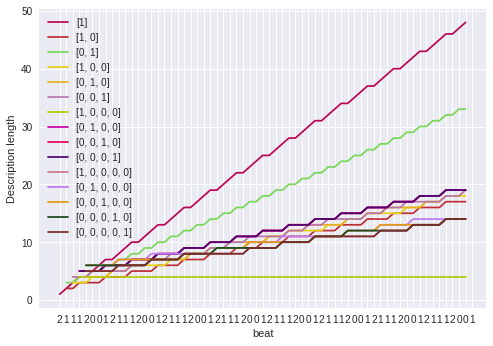

In [0]:
# simple clocks
fullbt = [2,1,1, 1, 2, 0, 0, 1] * 8
DLarr =[]

fig,ax = plt.subplots()
for clock in allclocks:
  DLarr.append({'DLarr':getDLarr(fullbt,clock),'clock':clock})
  plt.plot(getDLarr(fullbt,clock),color=np.random.rand(3))
plt.legend(allclocks)
plt.ylabel('Description length')
plt.xlabel('beat')

ax.set_xticks(np.arange(len(fullbt)))
ax.set_xticklabels(fullbt)
plt.show()

DLdf = pd.DataFrame(DLarr)


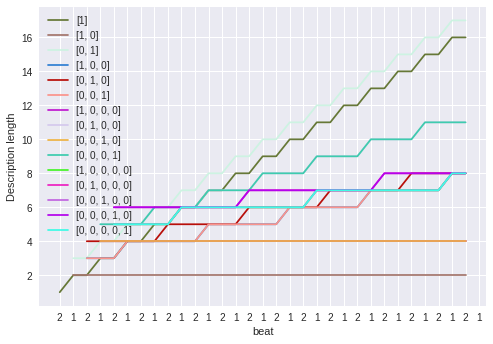

In [0]:
# simple clocks
fullbt = [2,1,2,1] * 8
DLarr =[]

fig,ax = plt.subplots()
for clock in allclocks:
  DLarr.append({'DLarr':getDLarr(fullbt,clock),'clock':clock})
  plt.plot(getDLarr(fullbt,clock),color=np.random.rand(3))
plt.legend(allclocks)
plt.ylabel('Description length')
plt.xlabel('beat')

ax.set_xticks(np.arange(len(fullbt)))
ax.set_xticklabels(fullbt)
plt.show()

DLdf = pd.DataFrame(DLarr)


Then we want more complexity. Like, when you discovery there's deviation, you might switch to a totally new thing (like a new chapter), or you combine the two -- build up a higher order structure to identify how they combine with each other.

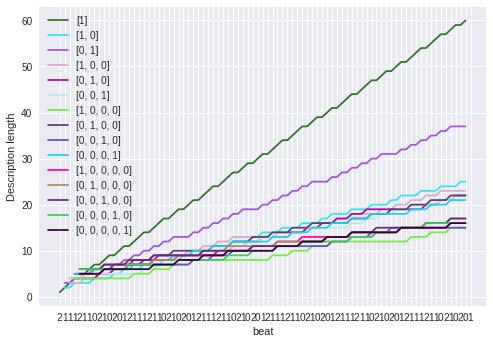

In [0]:
# compound clocks
# combination of [2,x,x,x] and [2,x,x]
fullbt=[2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1]
DLarr =[]

fig,ax = plt.subplots()
for clock in allclocks:
  DLarr.append({'DLarr':getDLarr(fullbt,clock),'clock':clock})
  plt.plot(getDLarr(fullbt,clock),color=np.random.rand(3))
plt.legend(allclocks)
plt.ylabel('Description length')
plt.xlabel('beat')

ax.set_xticks(np.arange(len(fullbt)))
ax.set_xticklabels(fullbt)
plt.show()

DLdf = pd.DataFrame(DLarr)

In [0]:
allclocks = []
for k in range(1,6):
  for kk in range(k):
    clock = [0]*k
    clock[kk]=1
    allclocks.append(clock)
# get the description length for each clock
def calcDL(data,clock):
  # data is the rythm in [0,1,2] coding list. We only care about 2 (accented notes) which should fit to the clock's stress
  clen = len(clock) # code length. assuming clock is recorded this way
  longclock = clock*int(len(data)/len(clock))
  if len(longclock):
    datalen=0
    for t,clk in enumerate(longclock):
      
      datalen += int(data[t]!=2)*clk # if clk = 0, whatever is the data; if clk =1, data should be 2.
    return datalen+clen
  else:
    return np.nan
def getDLarr(fulldata,clock):
  arr = []
  for k in range(1,len(fulldata)):
    arr.append(calcDL(fulldata[:k],clock))
  return arr
    

## Useful helpers
There are a lot of other helper methods sprinkled around the `magenta.music` codebase that you might need but not know where to find. Here are some of our favourites:

- [converting](https://github.com/tensorflow/magenta/blob/master/magenta/music/midi_io.py) between MIDI and NoteSequences
- [trimming, concatenating and expanding](https://github.com/tensorflow/magenta/blob/master/magenta/music/sequences_lib.py) NoteSequences
- [colab notebook](https://github.com/tensorflow/magenta/blob/master/magenta/music/notebook_utils.py) utils



```
# This is formatted as code
```

# Step 1: generate stims from formal generative model

## Generative model

In [10]:
# pattern generator: uniform for pattern length, uniform for each specific pattern. 
# here includes repetition. like 1010 is the same as 10 but not reduced. This will be dealt with latter
# also it contains like 0000. alternative: force there to be at least one 2. 
def gen_pattern(clock = []):
    
    if len(clock)==0: #no prior
        plen = random.randint(plenmax)+1 # pattern len minimum = 1
        pattern = [random.randint(nbtype) for k in range(plen)]  
        while 2 not in pattern:
            pattern = [random.randint(nbtype) for k in range(plen)]  
    else:
        pattern = [random.randint(nbtype) for k in clock]
        pattern[list(clock).index(2)] = 2
    return pattern

def ptn_devia(ptn,eps):
    for kp,p in enumerate(ptn):
        if random.rand()<eps:
            ptn[kp] = (p+random.randint(nbtype-1)+1)%nbtype # change p to something else
    return ptn

# repetition controller: transition probability like in markov model
def rep_controller(repnow=0):
    prep = fun_prep(repnow) # higher repetition => less likely to keep repeting. --wonder what's the corresponding prob distribution??
    dorep =  random.rand()<prep
    repnow += dorep
    return dorep
def fun_prep(repnow):
    return 1/(1.5+repnow)
def gen_clock():
    clen = random.randint(plenmax)+1
    clock = np.zeros(clen)
    clock[random.randint(clen)]=2
    return clock
def meta_controller(metaprior = 'simple',maxstep=36):        
    # generate beats by combining the controller and pattern generator
    allbts = []
    allpatterns = []
    # initialize with the first pattern
    if metaprior == 'stable_clock':
      clock = gen_clock()
      pattern = gen_pattern(clock)
      allbts += pattern
      allpatterns.append({'ptn':pattern,'nrep':0,'clock':clock})
    else:  
      pattern = gen_pattern()
      allbts += pattern
      allpatterns.append({'ptn':pattern,'nrep':0})
      
    # filling out the whole piece
    if metaprior == 'simple':
        # simplest model: just continue without refering to pervious patterns
        while len(allbts) < maxstep:
            thisptn = allpatterns[-1]        
            dorep = rep_controller(thisptn['nrep'])
            if dorep:
                allbts += ptn_devia(thisptn['ptn'],eps)
                thisptn['nrep'] += 1
            else:
                newptn = gen_pattern()
                allbts += ptn_devia(newptn,eps)
                allpatterns.append({'ptn':newptn,'nrep':0})
    elif metaprior == 'stable_clock':
        # prefer to keep the same clock
        while len(allbts) < maxstep:
            thisptn = allpatterns[-1]        
            dorep = rep_controller(thisptn['nrep'])
            if dorep:
                allbts += ptn_devia(thisptn['ptn'],eps)
                thisptn['nrep'] += 1
            else:
                if random.rand()<clkeps:
                  newptn = gen_pattern()
                else:
                  newptn = gen_pattern(clock)
                allbts += ptn_devia(newptn,eps)
                allpatterns.append({'ptn':newptn,'nrep':0,'clock':clock})            
    elif metaprior == 'VCVC': # verse, chorus, verse, chorus; in chorus the pattern is coherent        
        verselen = 4
        choruslen = 2
        # generate the first V-C structure
        for kstep in range(verselen-1):
            thisptn = allpatterns[-1]        
            dorep = rep_controller(thisptn['nrep'])
            if dorep:
                allbts += thisptn['ptn']
                thisptn['nrep'] += 1
            else:
                newptn = gen_pattern()
                allbts += newptn
                allpatterns.append({'ptn':newptn,'nrep':0})
        chorusptn = gen_pattern()        
        for k in range(choruslen):
            allbts += chorusptn
        allpatterns.append({'ptn':chorusptn,'nrep':choruslen})
        
        # generate the following, with small probability of changing to new beats
        while len(allbts) < maxstep:
            # TODO: small probility to change to new beats in the repetition
            allbts += allbts
            allpatterns +=allpatterns
            
    elif metaprior == 'comeback': # when transition to diff pattern, prefer patterns appeared before        
        while len(allbts) < maxstep:
            thisptn = allpatterns[-1]        
            dorep = rep_controller(thisptn['nrep'])
            if dorep:
                allbts += ptn_devia(thisptn['ptn'],eps)
                thisptn['nrep'] += 1
            else:
                newptn = gen_pattern()
                allbts += ptn_devia(newptn,eps)
                allpatterns.append({'ptn':newptn,'nrep':0})
        
    return allbts, allpatterns

In [8]:
def beat2midi(fullbt,doplay=False,dosave=False,fname=''):
  # speed
  bpm = 90
  bdura = 60/bpm/3 # each drum occupies 1/3 of the beat length. bc beats are bursts...
  

  # create sequence
  drums = music_pb2.NoteSequence()
  for k,kb in enumerate(fullbt):
    if kb:
      drums.notes.add(pitch=36, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
    if kb>1:
      drums.notes.add(pitch=42, start_time=k*bdura, end_time=(k+1)*bdura, is_drum=True, instrument=6,velocity=80) 
      # instrument & velocity: don't know how it affects anything

  # save midi file
  if dosave: 
    if len(fname)<1:
      raise Exception('Please specify the "fname" for saving.')
    mm.sequence_proto_to_midi_file(drums, fname)
    files.download(fname)

  # This is a colab utility method that plays a NoteSequence.
  if doplay:
    mm.play_sequence(drums,synth=mm.fluidsynth) 
    
  return drums
  

In [9]:
def ptn2beats(ptngrp):
    bts =[]
    for ptn in ptngrp:
        for krep in range(ptn['nrep']):
            bts += ptn_devia(ptn['ptn'],eps)
    return bts

In [0]:
# test on diff clocks
bt = [0,1,1,1,0,0,2,0,1,1,0,1,1,0,2,1,0,0,2,0]*4
drum = beat2midi(bt)
mm.play_sequence(drum,synth=mm.fluidsynth) 

Intuitively, the clock manipulation certainly works for me. 

a) 2 is more salient than 1 and will naturally be marked as an accented note; 

b) do feel there's a steady tempo (not neccesarily clear about 3/4 or 4/4 but at least will recognize the cycles)

c) when there's accented note missing: if not too many missing, other accents will still help to define the cycles.

d) however, **if there's additional accents**, may be hard to follow.

### Now generate! 

In [11]:
# general settings used for both generative model and fitting
plenmax=5
nbtype = 3 # in total three types of beat
eps = 0.1 # probability of small variation
clkeps = 0.1# probability of swtiching to new clock

In [ ]:
### generate with model

In [0]:
rhythms = {'beats':[],'ptngrp':[],'drums':[]}
prilabel='stable_clock'#'simple'
dolisten=1
for k in range(5):
  allbts, allpatterns=meta_controller(metaprior = prilabel,maxstep=36)
  rhythms['drums'].append(beat2midi(allbts,False,False,'%s_%d'%(prilabel,k)))
  rhythms['beats'].append(allbts)
  rhythms['ptngrp'].append(allpatterns)
  if dolisten:
      print(allpatterns)
      mm.play_sequence(rhythms['drums'][-1],synth=mm.fluidsynth) 

[{'ptn': [0, 2, 0, 1, 2], 'nrep': 0, 'clock': array([0., 2., 0., 0., 0.])}, {'ptn': [2, 2, 0, 0, 1], 'nrep': 0, 'clock': array([0., 2., 0., 0., 0.])}, {'ptn': [2, 2, 1, 2, 0], 'nrep': 0, 'clock': array([0., 2., 0., 0., 0.])}, {'ptn': [0, 2, 0, 0, 2], 'nrep': 0, 'clock': array([0., 2., 0., 0., 0.])}, {'ptn': [0, 2, 0, 2, 1], 'nrep': 0, 'clock': array([0., 2., 0., 0., 0.])}, {'ptn': [2, 2, 2, 0, 2], 'nrep': 2, 'clock': array([0., 2., 0., 0., 0.])}]


[{'ptn': [2, 2, 2, 0], 'nrep': 0, 'clock': array([0., 2., 0., 0.])}, {'ptn': [2, 0], 'nrep': 1, 'clock': array([0., 2., 0., 0.])}, {'ptn': [0, 2, 2, 1], 'nrep': 2, 'clock': array([0., 2., 0., 0.])}, {'ptn': [2, 0], 'nrep': 3, 'clock': array([0., 2., 0., 0.])}, {'ptn': [2, 2, 1, 0], 'nrep': 0, 'clock': array([0., 2., 0., 0.])}, {'ptn': [2, 2, 0, 1], 'nrep': 0, 'clock': array([0., 2., 0., 0.])}]


[{'ptn': [0, 1, 1, 1, 2], 'nrep': 0, 'clock': array([0., 0., 0., 0., 2.])}, {'ptn': [0, 0, 0, 0, 2], 'nrep': 0, 'clock': array([0., 0., 0., 0., 2.])}, {'ptn': [1, 0, 2, 1, 2], 'nrep': 1, 'clock': array([0., 0., 0., 0., 2.])}, {'ptn': [0, 2, 0, 0, 2], 'nrep': 1, 'clock': array([0., 0., 0., 0., 2.])}, {'ptn': [2, 0, 1, 2, 1], 'nrep': 1, 'clock': array([0., 0., 0., 0., 2.])}]


[{'ptn': [2, 2], 'nrep': 0, 'clock': array([2., 0.])}, {'ptn': [2, 0], 'nrep': 3, 'clock': array([2., 0.])}, {'ptn': [2, 1], 'nrep': 0, 'clock': array([2., 0.])}, {'ptn': [2], 'nrep': 0, 'clock': array([2., 0.])}, {'ptn': [2, 1], 'nrep': 0, 'clock': array([2., 0.])}, {'ptn': [2, 2], 'nrep': 1, 'clock': array([2., 0.])}, {'ptn': [2, 0], 'nrep': 1, 'clock': array([2., 0.])}, {'ptn': [0, 2], 'nrep': 1, 'clock': array([2., 0.])}, {'ptn': [2, 0], 'nrep': 0, 'clock': array([2., 0.])}, {'ptn': [2, 2], 'nrep': 1, 'clock': array([2., 0.])}, {'ptn': [2, 1], 'nrep': 1, 'clock': array([2., 0.])}]


[{'ptn': [2, 1, 2], 'nrep': 0, 'clock': array([2., 0., 0.])}, {'ptn': [2, 2, 2], 'nrep': 1, 'clock': array([2., 0., 0.])}, {'ptn': [2, 2, 0], 'nrep': 2, 'clock': array([2., 0., 0.])}, {'ptn': [2, 0, 2], 'nrep': 1, 'clock': array([2., 0., 0.])}, {'ptn': [2, 2, 2], 'nrep': 2, 'clock': array([2., 0., 0.])}, {'ptn': [0, 2, 0, 2], 'nrep': 0, 'clock': array([2., 0., 0.])}]


## model complexity evaluation



In [19]:
def ptn_ll(ptn,data):
    ll=0
    for k,beat in enumerate(data):
        plen = len(ptn)
        ll+=np.log((ptn[k%plen]==beat)*(1-eps) +(ptn[k%plen]!=beat)*eps )
    return ll
  
def ptn_logprior(ptn,metaprior,args=[]):
    if metaprior=='simple': #uniform prior on all pattern length & specific pattern under the length
      prior = 1/plenmax/(nbtype**len(ptn) - (nbtype-1)**len(ptn)) # exclude patterns without a stress (2)
    elif metaprior=='stable_clock':
      
      if list(args['prevclock'])!= list(args['clock']): # clock is diff
        prior = clkeps*(1/plenmax/(nbtype**len(ptn) - (nbtype-1)**len(ptn)))
      else: #same clock, so besides the accented notes everything else can change
        prior = (1-clkeps)/(nbtype-1)**len(ptn)

    else:
      print('metaprior wrong label!%s'%metaprior)
      return np.nan
    return np.log(prior)  
  
def stim_posterior(ptns,data,metaprior='simple'):
    logpstr=0
    idx=0
    for kp,ptn in enumerate(ptns):
        nrep = ptn['nrep']
        for k in range(nrep):
            logpstr += np.log(fun_prep(k)) # prob of repeating
        if ptn != ptns[-1]:# if not the end, prob of transitioning to the next pattern
            logpstr += np.log(1-fun_prep(nrep)) 
        # get the pattern likelihood for the corresponding chunk
        ptnlen=len(ptn['ptn'])*ptn['nrep']
        chunk = data[idx:idx+ptnlen]
        idx=idx+ptnlen
        logpstr+=ptn_ll(ptn['ptn'],chunk)
        # get prior of this pattern
        if metaprior == 'simple':
            logpstr += ptn_logprior(ptn['ptn'],'simple')
        elif metaprior == 'stable_clock':
            if kp==0: #no prev history
              logpstr += ptn_logprior(ptn['ptn'],'simple')
            else:
              logpstr += ptn_logprior(ptn['ptn'],'stable_clock',{'prevclock':ptns[kp-1]['clock'],'clock':ptn['clock']})
    return logpstr

### Hand-generation

In [50]:
ptgrp =[]
# first, same clock. pred to have high prob in clock model but low in simple model
ptgrp.append([{'ptn':[2,1,0,1],'nrep':3,'clock':[2,0,0,0]},{'ptn':[2,0,1,1],'nrep':2,'clock':[2,0,0,0]},{'ptn':[2,2,1,0],'nrep':3,'clock':[2,0,0,0]}])
# second, with clock change for every pattern
ptgrp.append([{'ptn':[1,2,1],'nrep':2,'clock':[0,2,0]},{'ptn':[2,1,0,1],'nrep':2,'clock':[2,0,0,0]},{'ptn':[1,2,0],'nrep':2,'clock':[0,2,0]},{'ptn':[1,0,2],'nrep':2,'clock':[0,0,2]}])

allbts=[]
eps=0.05 #addint some randomness in actual beat generation
for pt in ptgrp:
    allbts.append(ptn2beats(pt))
rhythms = {'beats':allbts,'ptngrp':ptgrp}

### Now evaluate!


In [51]:
rhythms['posterior_sclk']=[[] for k in rhythms['ptngrp']]
rhythms['posterior_simple']=[[] for k in rhythms['ptngrp']]
for k in range(len(rhythms['ptngrp'])):
  rhythms['posterior_sclk'][k]=stim_posterior(rhythms['ptngrp'][k],rhythms['beats'][k],metaprior='stable_clock')
  rhythms['posterior_simple'][k]=stim_posterior(rhythms['ptngrp'][k],rhythms['beats'][k],metaprior='simple')

In [52]:
df_rhms=pd.DataFrame(rhythms)
df_rhms= df_rhms.sort_values('posterior_simple')
df_rhms

,beats,posterior_sclk,posterior_simple,ptngrp
0,"[2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 0, 1, ...",-23.184128,-28.995880,"[{u'ptn': [2, 1, 0, 1], u'nrep': 3, u'clock': ..."
1,"[1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 1, 0, 1, 1, ...",-33.983277,-27.075522,"[{u'ptn': [1, 2, 1], u'nrep': 2, u'clock': [0,..."


### compare 

In [0]:

for k in range(len(df_rhms)):
  fname = 'simple_%d'%k      
  if len(fname)<1:
      raise Exception('Please specify the "fname" for saving.')
  mm.sequence_proto_to_midi_file(df_rhms['drums'].iloc[k], fname)
  files.download(fname)


In [0]:
for k in range(len(df_rhms)):
  print([df_rhms['posterior_sclk'].iloc[k],df_rhms['posterior_simple'].iloc[k]])
  #mm.play_sequence(df_rhms['drums'].iloc[k],synth=mm.fluidsynth) 

[-55.24824702804656, -67.42031675752392]
[-44.70091584233189, -61.056834591362566]
[-43.67132346478016, -60.622321602043236]
[-44.839157222490215, -58.39995573230068]
[-39.69574558766669, -52.077920869150326]


# That's it!

You're now ready to build your own amazing, Machine Learning powered, music instrument! If you want more information, you can check out:

- some [demos](https://magenta.tensorflow.org/demos) `#MadeWithMagenta`
- some more of our [Colab notebooks](https://magenta.tensorflow.org/demos#colab-notebooks)
- the [documentation](https://github.com/tensorflow/magenta)
- the [Magenta blog](https://magenta.tensorflow.org/blog), which talks about all the mathy bits we skipped.

Have fun! 💕